In [1]:
!pip install pytorch-toolbelt --quiet
!pip install einops --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 798.0 kB/s eta 0:00:00


In [2]:
!git clone https://github.com/LeeJunHyun/Image_Segmentation
!git clone https://github.com/gorkemcanates/Dual-Cross-Attention
!mv Dual-Cross-Attention Dual_Cross_Attention

Cloning into 'Image_Segmentation'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 54 (delta 0), reused 2 (delta 0), pack-reused 51
Receiving objects: 100% (54/54), 265.66 KiB | 3.09 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Cloning into 'Dual-Cross-Attention'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 331 (delta 99), reused 101 (delta 49), pack-reused 124
Receiving objects: 100% (331/331), 4.70 MiB | 18.37 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset: https://www.kaggle.com/datasets/c7934597/cardiac-catheterization

%mkdir dataset
!unzip -o 'drive/MyDrive/Kaggle/cardiac-catheterization.zip' -d 'dataset'

In [5]:
import os
import random
from matplotlib import pyplot as plt

import numpy as np
import cv2

from torch import nn
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from pytorch_toolbelt.losses.lovasz import BinaryLovaszLoss

from sklearn.model_selection import train_test_split

cudnn.benchmark = True
cuda = torch.cuda.is_available()

#Loading Data

In [6]:
images_directory = 'dataset/Cardiac_Catheterization/train/images/'
masks_directory = 'dataset/Cardiac_Catheterization/train/masks/'

images_files = os.listdir(images_directory)
masks_files = os.listdir(masks_directory)

sample_image = cv2.imread(images_directory + images_files[0], flags=cv2.IMREAD_GRAYSCALE)

print('images count: ' + str(len(images_files)))
print('images shape: ' + str(sample_image.shape))

images count: 1717
images shape: (512, 512)


In [7]:
image_size = 128
images = []
masks = []

for i, image_name in enumerate(images_files):
    image = cv2.imread(images_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    images.append(image)

for i, image_name in enumerate(masks_files):
    image = cv2.imread(masks_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    masks.append(image)

print('images shape: ' + str(images[0].shape))
print('masks shape: ' + str(masks[0].shape))

images shape: (128, 128)
masks shape: (128, 128)


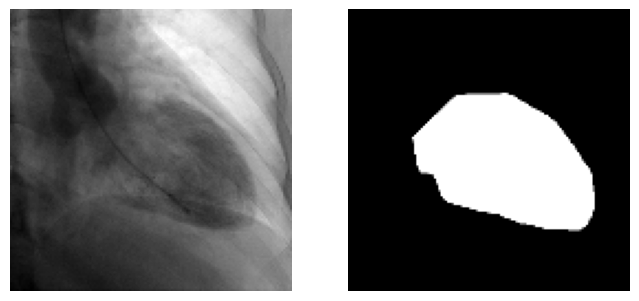

In [8]:
idx = random.randint(0, len(images))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(images[idx], cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(masks[idx], cmap='gray')
plt.show()

In [9]:
# create train and test datasets

batch_size = 16

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        # # Add channel dimension
        image = torch.from_numpy(image / 255.0).unsqueeze(0)
        mask = torch.from_numpy(mask / 255.0).unsqueeze(0)

        # Add channel dimension
        # image = torch.from_numpy(image).unsqueeze(0)
        # mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask


x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

train_dataset = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = Dataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

len(train_loader) * batch_size, len(test_loader) * batch_size

(1360, 336)

#Model

In [10]:
# accuracy metric

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Correct predictions
    correct = (y_true == y_pred).sum()

    # Accuracy calculation
    accuracy = correct / float(y_true.numel())

    return accuracy


def jaccard_index(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = (y_true * y_pred).sum()
    union = torch.logical_or(y_true, y_pred).sum()

    # Avoid division by zero
    jaccard = torch.where(union != 0.0, intersection / union, torch.tensor(0.0))

    return jaccard


def dice_coefficient(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum()

    # Avoid division by zero
    dice = torch.where(union != 0.0, (2 * intersection) / union, torch.tensor(0.0))

    return dice

In [11]:
# Model

class OneConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OneConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.double_conv(x)
        return x


class DownRes(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownRes, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.mp_conv = DoubleConv(in_ch, out_ch)
        self.bridge = OneConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x_1 = self.mp_conv(x)
        x_2 = self.bridge(x)
        x = x_1 + x_2
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        padding = [(x1.size()[2] - x2.size()[2]) // 2, (x1.size()[2] - x2.size()[2] + 1) // 2,
                   (x1.size()[3] - x2.size()[3]) // 2, (x1.size()[3] - x2.size()[3] + 1) // 2]
        x2 = nn.functional.pad(x2, padding)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UpRes(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(UpRes, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=(2, 2), stride=(2, 2))

        self.conv = DoubleConv(in_ch, out_ch)
        self.bridge = OneConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        padding = [(x1.size()[2] - x2.size()[2]) // 2, (x1.size()[2] - x2.size()[2] + 1) // 2,
                   (x1.size()[3] - x2.size()[3]) // 2, (x1.size()[3] - x2.size()[3] + 1) // 2]
        x2 = nn.functional.pad(x2, padding)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x) + self.bridge(x)
        return x


class Model(nn.Module):
    def __init__(self, model_type, n_channels=1, n_classes=1):
        super(Model, self).__init__()
        f = 4

        self.in_conv = DoubleConv(n_channels, f)

        if model_type == 'UNet':
            self.down1 = Down(f, f * 2)
            self.down2 = Down(f * 2, f * 4)
            self.down3 = Down(f * 4, f * 8)
            self.down4 = Down(f * 8, f * 8)

            self.up1 = Up(f * 16, f * 4)
            self.up2 = Up(f * 8, f * 2)
            self.up3 = Up(f * 4, f)
            self.up4 = Up(f * 2, f)

        elif model_type == 'ResNet':
            self.down1 = DownRes(f, f * 2)
            self.down2 = DownRes(f * 2, f * 4)
            self.down3 = DownRes(f * 4, f * 8)
            self.down4 = DownRes(f * 8, f * 8)

            self.up1 = UpRes(f * 16, f * 4)
            self.up2 = UpRes(f * 8, f * 2)
            self.up3 = UpRes(f * 4, f)
            self.up4 = UpRes(f * 2, f)

        self.out = OneConv(f, n_classes)

        if n_classes == 1:
            self.out_activation = F.sigmoid
        elif n_classes > 1:
            self.out_activation = F.softmax

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return self.out_activation(x)


In [12]:
class ModelFit:
    def __init__(self, model, criterion=None, optimizer=None, metrics=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.train_loader = None
        self.test_loader = None

        if self.criterion is None:
            self.criterion = nn.BCELoss()

        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

        if self.metrics is None:
            self.metrics = [accuracy, dice_coefficient, jaccard_index]

        self.metrics_names = [f.__name__ for f in self.metrics]

        self.cuda = torch.cuda.is_available()
        if self.cuda:
            self.model.cuda()
            self.criterion.cuda()

    def _train_batch(self, inputs, targets):
        if self.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
        metrics = [metric(targets, outputs).item() for metric in self.metrics]

        return loss.item(), metrics

    def _test_batch(self, inputs, targets):
        if self.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        metrics = [metric(targets, outputs).item() for metric in self.metrics]

        return loss.item(), metrics

    def _train_epoch(self, epoch, epochs):
        self.model.train()

        epoch_loss = 0
        epoch_metrics = np.zeros((len(self.metrics)))
        batches_n = len(self.train_loader)
        i = 0

        for inputs, targets in self.train_loader:
            i += 1

            loss, metrics = self._train_batch(inputs, targets)

            epoch_loss += loss
            epoch_metrics += np.array(metrics)

            info = f"\rEpoch: {f'{epoch}/{epochs}':<7} Batch: {f'{i}/{batches_n}':<7} [ loss: {epoch_loss / i:.4f}"
            for n in range(len(self.metrics)):
                info += f" - {self.metrics_names[n]}: {epoch_metrics[n] / i:.4f}"
            info += " ]"

            print(info, end='')

        epoch_loss /= batches_n
        epoch_metrics /= batches_n
        return epoch_loss, epoch_metrics

    def _test_epoch(self):
        self.model.eval()

        epoch_loss = 0
        epoch_metrics = np.zeros((len(self.metrics)))
        batches_n = len(self.test_loader)

        for inputs, targets in self.test_loader:
            loss, metrics = self._test_batch(inputs, targets)

            epoch_loss += loss
            epoch_metrics += np.array(metrics)

        epoch_loss /= batches_n
        epoch_metrics /= batches_n

        info = f" [ val_loss: {epoch_loss:.4f}"
        for n in range(len(self.metrics)):
            info += f" - val_{self.metrics_names[n]}: {epoch_metrics[n]:.4f}"
        info += " ]"

        print(info)

        return epoch_loss, epoch_metrics

    def fit(self, train_loader, epochs, test_loader=None):
        self.train_loader = train_loader
        self.test_loader = test_loader

        train_loss_history = []
        train_metrics_history = []
        test_loss_history = []
        test_metrics_history = []

        for epoch in range(epochs):
            loss, accuracy = self._train_epoch(epoch + 1, epochs)
            train_loss_history.append(loss)
            train_metrics_history.append(accuracy)

            if self.test_loader is not None:
                test_loss, test_accuracy = self._test_epoch()
                test_loss_history.append(test_loss)
                test_metrics_history.append(test_accuracy)

        result = {}
        result['train_loss'] = train_loss_history
        result['val_loss'] = test_loss_history

        for i, metric in enumerate(zip(*train_metrics_history)):
            result['train_' + self.metrics_names[i]] = metric

        for i, metric in enumerate(zip(*test_metrics_history)):
            result['val_' + self.metrics_names[i]] = metric

        print('\n')
        return result

    def evaluate():
        pass

In [13]:
# plotting

def plot_metric(history, metric):
    plt.figure(figsize=(10, 4))

    epochs = range(1, len(history['train_' + metric]) + 1)

    plt.plot(epochs, history['train_' + metric], label='train ' + metric)
    plt.plot(epochs, history['val_' + metric], label='test ' + metric)

    plt.xlabel('epoch')
    plt.ylabel(metric)

    plt.legend()
    plt.grid(True)

    plt.show()


def evaluate(model, data_loader, metric=dice_coefficient):
    model.eval()

    if cuda:
        model.cuda()

    s = 0
    batches_n = len(data_loader)

    for inputs, targets in data_loader:
        if cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)
        s += metric(targets, outputs)

    result = (s / batches_n)
    if torch.is_tensor(result):
        result = result.item()
    return result


def tensor_to_numpy_image(img):
    img = img.cpu()
    img = img.data.numpy().astype(np.float32)
    # img = img.transpose(1, 2, 0)  # (1, 128, 128) -> (128, 128, 1)
    return img.T


def check(model, idx=None):
    model.eval()

    if idx is None:
        idx = random.randint(0, len(test_dataset))

    x, y = test_dataset[idx]

    inputs = x.unsqueeze(0)
    if cuda:
        inputs = inputs.cuda()

    y_pred = model(inputs)[0]
    y_pred = tensor_to_numpy_image(y_pred)

    prediction = (y_pred > 0.5)
    x = tensor_to_numpy_image(x)
    y = tensor_to_numpy_image(y)

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 3, 1)
    plt.title('Image')
    plt.axis('off')
    plt.imshow(x, cmap='gray')

    plt.subplot(2, 3, 2)
    plt.title('Real Mask')
    plt.axis('off')
    plt.imshow(y, cmap='gray')

    plt.subplot(2, 3, 3)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.imshow(prediction, cmap='gray')

    plt.show()

#Loss Functions

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = (self.alpha * pt) * torch.pow(1.0 - pt, self.gamma)
        loss = focal_loss.mean()
        return loss


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        loss = 1 - (2 * intersection) / (inputs.sum() + targets.sum() + 1e-5)
        return loss


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        bce_loss = self.bce_loss(inputs, targets)
        loss = 0.5 * (dice_loss + bce_loss)
        return loss


class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

        self.sobel_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        # Initialize Sobel filters with weights
        self.sobel_x.weight.data.copy_(torch.tensor([[-1, 0, 1], [2, 0, -2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3))
        self.sobel_y.weight.data.copy_(torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3))

    def compute_length(self, inputs):
        # Get segmentation with maximum along channel dimension
        seg_channel = torch.argmax(inputs, dim=1, keepdim=True).float()  # keepdim for efficient operation

        # Apply edge filters and compute sum of squared filter response
        edges_x = self.sobel_x(seg_channel)
        edges_y = self.sobel_y(seg_channel)
        edges = torch.square(edges_x) + torch.square(edges_y)
        length = torch.sum(edges, dim=[1, 2, 3])  # Sum over all channels and spatial dimensions

        # Improve numerical stability with epsilon
        length = torch.mean(length + 1e-6)

        return length

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)
        length = self.compute_length(inputs)

        return bce_loss - 0.1 * dice_loss + length


class LovaszBCELoss(nn.Module):
    def __init__(self):
        super(LovaszBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.lovasz_loss = BinaryLovaszLoss()

    def forward(self, inputs, targets):
        loss = self.bce_loss(inputs, targets) + self.lovasz_loss(inputs, targets)
        return loss

#Checking model with different losses

In [15]:
epochs = 10

models = []
base_models_names = []
base_accuracies = []

def check_loss(model_type, criterion):
    model = Model(model_type)

    model_fit = ModelFit(model, criterion)
    history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)

    models.append(model)
    name = f"{model_type} model with {criterion.__class__.__name__}"
    base_models_names.append(name)
    base_accuracies.append(history['val_dice_coefficient'][-1])

    plot_metric(history, 'dice_coefficient')

    for i in range(0):
        print()
        check(model, i)


UNet model with MSELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.2271 - accuracy: 0.9403 - dice_coefficient: 0.8336 - jaccard_index: 0.7314 ] [ val_loss: 0.2215 - val_accuracy: 0.9717 - val_dice_coefficient: 0.9093 - val_jaccard_index: 0.8261 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.2189 - accuracy: 0.9743 - dice_coefficient: 0.9242 - jaccard_index: 0.8543 ] [ val_loss: 0.2187 - val_accuracy: 0.9777 - val_dice_coefficient: 0.9329 - val_jaccard_index: 0.8678 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.2176 - accuracy: 0.9778 - dice_coefficient: 0.9354 - jaccard_index: 0.8734 ] [ val_loss: 0.2182 - val_accuracy: 0.9793 - val_dice_coefficient: 0.9373 - val_jaccard_index: 0.8747 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.2168 - accuracy: 0.9803 - dice_coefficient: 0.9434 - jaccard_index: 0.8874 ] [ val_loss: 0.2175 - val_accuracy: 0.9805 - val_dice_coefficient: 0.9438 - val_jaccard_index: 0.8886 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.2162 - accuracy: 0.9816 - dice_coefficient: 0.9474 - ja

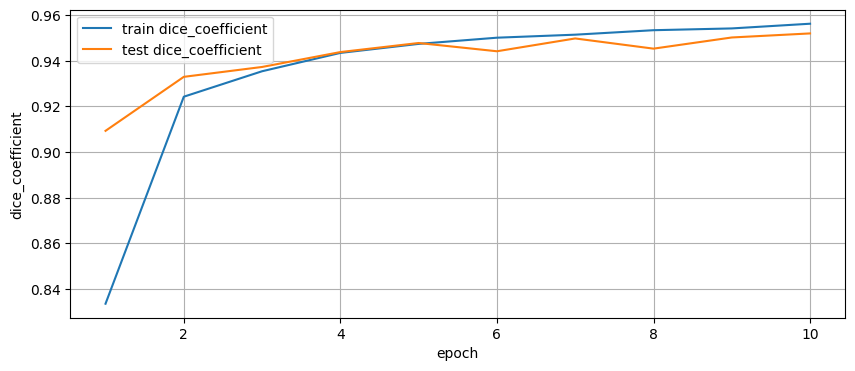


ResNet model with MSELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.2354 - accuracy: 0.8251 - dice_coefficient: 0.7069 - jaccard_index: 0.5827 ] [ val_loss: 0.2215 - val_accuracy: 0.9668 - val_dice_coefficient: 0.8963 - val_jaccard_index: 0.8063 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.2194 - accuracy: 0.9712 - dice_coefficient: 0.9137 - jaccard_index: 0.8361 ] [ val_loss: 0.2190 - val_accuracy: 0.9757 - val_dice_coefficient: 0.9270 - val_jaccard_index: 0.8583 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.2183 - accuracy: 0.9752 - dice_coefficient: 0.9264 - jaccard_index: 0.8574 ] [ val_loss: 0.2184 - val_accuracy: 0.9765 - val_dice_coefficient: 0.9307 - val_jaccard_index: 0.8654 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.2174 - accuracy: 0.9780 - dice_coefficient: 0.9358 - jaccard_index: 0.8739 ] [ val_loss: 0.2182 - val_accuracy: 0.9775 - val_dice_coefficient: 0.9317 - val_jaccard_index: 0.8651 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.2168 - accuracy: 0.9796 - dice_coefficient: 0.9408 -

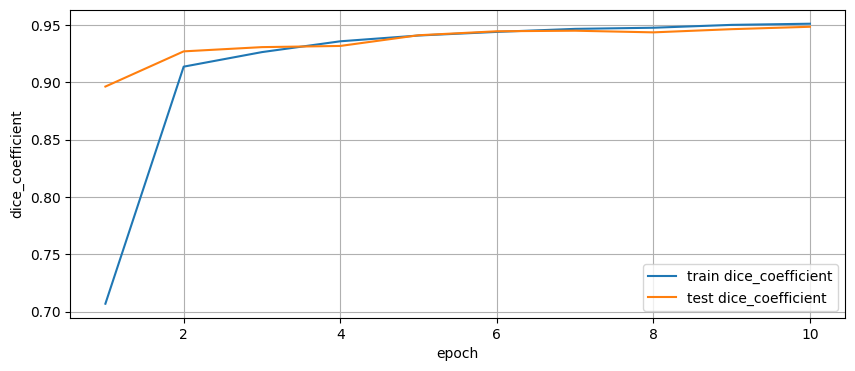


UNet model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.6419 - accuracy: 0.9362 - dice_coefficient: 0.8170 - jaccard_index: 0.7071 ] [ val_loss: 0.6295 - val_accuracy: 0.9677 - val_dice_coefficient: 0.8939 - val_jaccard_index: 0.8008 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6182 - accuracy: 0.9721 - dice_coefficient: 0.9175 - jaccard_index: 0.8430 ] [ val_loss: 0.6193 - val_accuracy: 0.9750 - val_dice_coefficient: 0.9230 - val_jaccard_index: 0.8506 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.6138 - accuracy: 0.9762 - dice_coefficient: 0.9306 - jaccard_index: 0.8656 ] [ val_loss: 0.6140 - val_accuracy: 0.9770 - val_dice_coefficient: 0.9326 - val_jaccard_index: 0.8691 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.6117 - accuracy: 0.9776 - dice_coefficient: 0.9347 - jaccard_index: 0.8725 ] [ val_loss: 0.6147 - val_accuracy: 0.9771 - val_dice_coefficient: 0.9301 - val_jaccard_index: 0.8622 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.6100 - accuracy: 0.9787 - dice_coefficient: 0.9381 - j

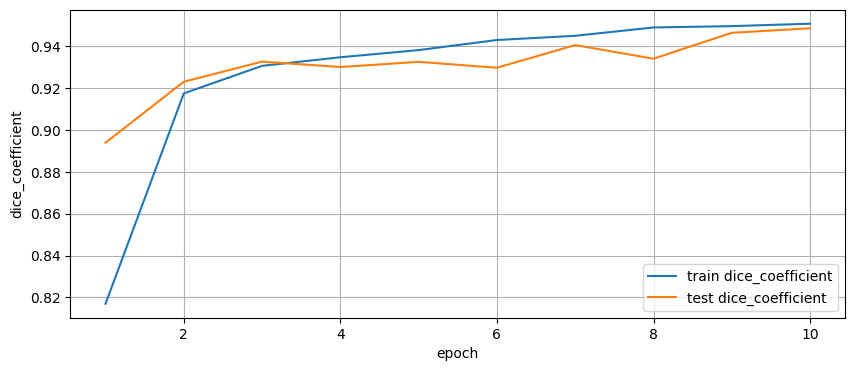


ResNet model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.6389 - accuracy: 0.9325 - dice_coefficient: 0.8327 - jaccard_index: 0.7314 ] [ val_loss: 0.6231 - val_accuracy: 0.9650 - val_dice_coefficient: 0.8968 - val_jaccard_index: 0.8095 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6173 - accuracy: 0.9724 - dice_coefficient: 0.9182 - jaccard_index: 0.8441 ] [ val_loss: 0.6167 - val_accuracy: 0.9708 - val_dice_coefficient: 0.9153 - val_jaccard_index: 0.8405 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.6139 - accuracy: 0.9760 - dice_coefficient: 0.9297 - jaccard_index: 0.8636 ] [ val_loss: 0.6160 - val_accuracy: 0.9773 - val_dice_coefficient: 0.9305 - val_jaccard_index: 0.8629 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.6110 - accuracy: 0.9788 - dice_coefficient: 0.9385 - jaccard_index: 0.8789 ] [ val_loss: 0.6128 - val_accuracy: 0.9793 - val_dice_coefficient: 0.9374 - val_jaccard_index: 0.8747 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.6090 - accuracy: 0.9803 - dice_coefficient: 0.9432 -

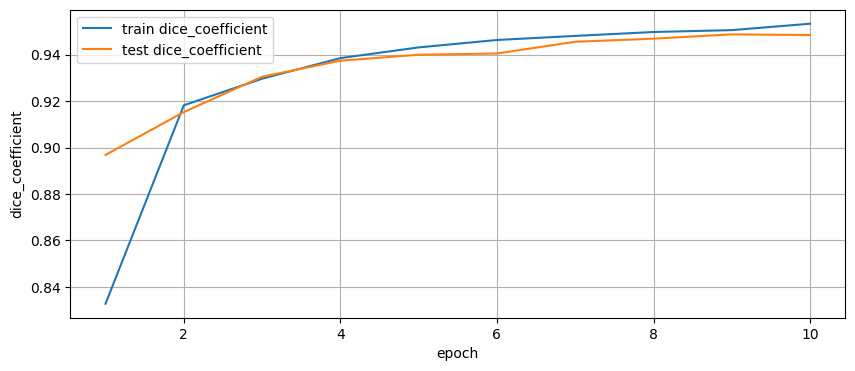


UNet model with FocalLoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.0584 - accuracy: 0.9464 - dice_coefficient: 0.8503 - jaccard_index: 0.7513 ] [ val_loss: 0.0574 - val_accuracy: 0.9724 - val_dice_coefficient: 0.9176 - val_jaccard_index: 0.8432 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.0571 - accuracy: 0.9750 - dice_coefficient: 0.9263 - jaccard_index: 0.8576 ] [ val_loss: 0.0569 - val_accuracy: 0.9770 - val_dice_coefficient: 0.9320 - val_jaccard_index: 0.8676 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0568 - accuracy: 0.9775 - dice_coefficient: 0.9340 - jaccard_index: 0.8709 ] [ val_loss: 0.0568 - val_accuracy: 0.9771 - val_dice_coefficient: 0.9313 - val_jaccard_index: 0.8657 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0566 - accuracy: 0.9788 - dice_coefficient: 0.9382 - jaccard_index: 0.8782 ] [ val_loss: 0.0567 - val_accuracy: 0.9797 - val_dice_coefficient: 0.9403 - val_jaccard_index: 0.8817 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0564 - accuracy: 0.9806 - dice_coefficient: 0.9441 -

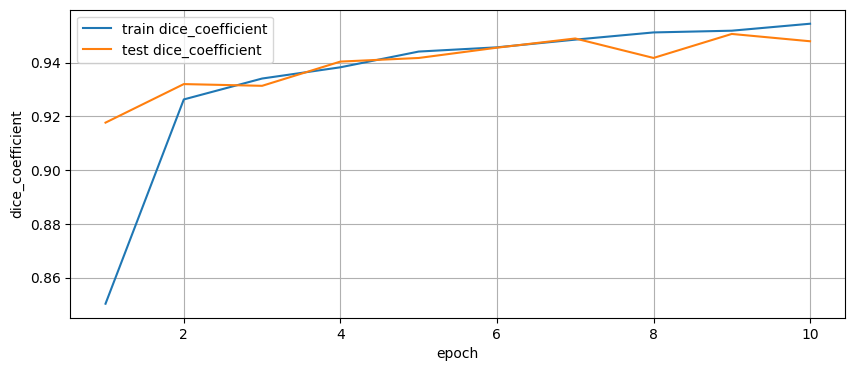


ResNet model with FocalLoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.0597 - accuracy: 0.8210 - dice_coefficient: 0.7012 - jaccard_index: 0.5785 ] [ val_loss: 0.0577 - val_accuracy: 0.9682 - val_dice_coefficient: 0.9023 - val_jaccard_index: 0.8166 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.0572 - accuracy: 0.9722 - dice_coefficient: 0.9173 - jaccard_index: 0.8423 ] [ val_loss: 0.0572 - val_accuracy: 0.9768 - val_dice_coefficient: 0.9296 - val_jaccard_index: 0.8617 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0569 - accuracy: 0.9765 - dice_coefficient: 0.9308 - jaccard_index: 0.8652 ] [ val_loss: 0.0573 - val_accuracy: 0.9695 - val_dice_coefficient: 0.9122 - val_jaccard_index: 0.8363 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0567 - accuracy: 0.9783 - dice_coefficient: 0.9367 - jaccard_index: 0.8755 ] [ val_loss: 0.0567 - val_accuracy: 0.9801 - val_dice_coefficient: 0.9416 - val_jaccard_index: 0.8835 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0565 - accuracy: 0.9805 - dice_coefficient: 0.9439

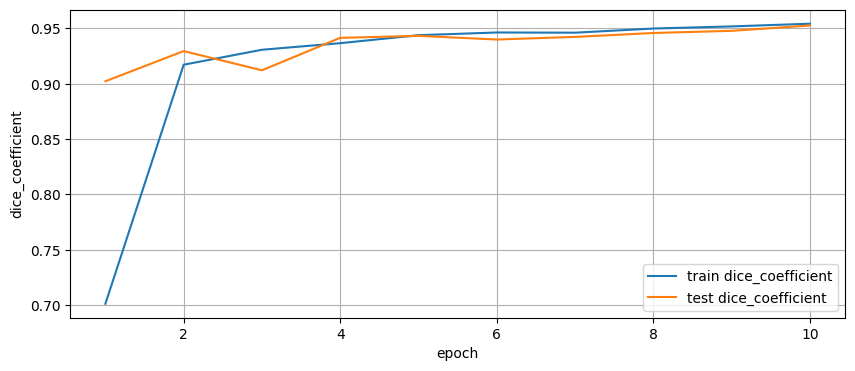


UNet model with DiceLoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.6381 - accuracy: 0.8813 - dice_coefficient: 0.7446 - jaccard_index: 0.6125 ] [ val_loss: 0.6251 - val_accuracy: 0.9493 - val_dice_coefficient: 0.8581 - val_jaccard_index: 0.7499 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6119 - accuracy: 0.9541 - dice_coefficient: 0.8731 - jaccard_index: 0.7741 ] [ val_loss: 0.6165 - val_accuracy: 0.9653 - val_dice_coefficient: 0.9007 - val_jaccard_index: 0.8173 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.6055 - accuracy: 0.9605 - dice_coefficient: 0.8901 - jaccard_index: 0.8009 ] [ val_loss: 0.6082 - val_accuracy: 0.9565 - val_dice_coefficient: 0.8794 - val_jaccard_index: 0.7839 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.6011 - accuracy: 0.9652 - dice_coefficient: 0.9026 - jaccard_index: 0.8216 ] [ val_loss: 0.6039 - val_accuracy: 0.9678 - val_dice_coefficient: 0.9084 - val_jaccard_index: 0.8306 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.5975 - accuracy: 0.9677 - dice_coefficient: 0.9093 - 

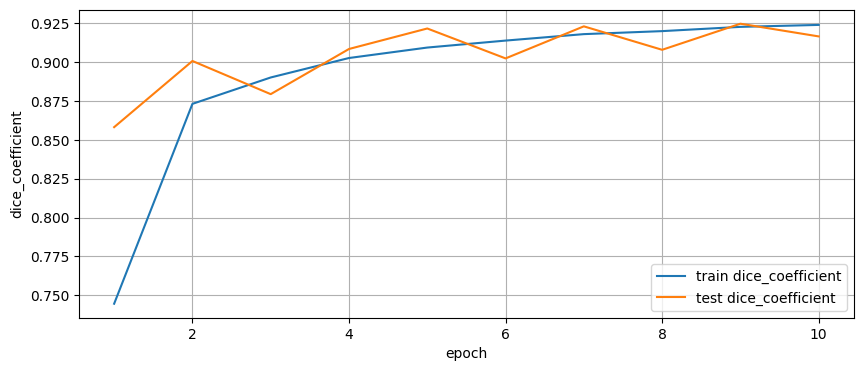


ResNet model with DiceLoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.6329 - accuracy: 0.9097 - dice_coefficient: 0.7794 - jaccard_index: 0.6546 ] [ val_loss: 0.6231 - val_accuracy: 0.9571 - val_dice_coefficient: 0.8791 - val_jaccard_index: 0.7828 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6109 - accuracy: 0.9559 - dice_coefficient: 0.8782 - jaccard_index: 0.7822 ] [ val_loss: 0.6163 - val_accuracy: 0.9673 - val_dice_coefficient: 0.9056 - val_jaccard_index: 0.8254 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.6040 - accuracy: 0.9619 - dice_coefficient: 0.8942 - jaccard_index: 0.8079 ] [ val_loss: 0.6071 - val_accuracy: 0.9640 - val_dice_coefficient: 0.8986 - val_jaccard_index: 0.8145 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.6003 - accuracy: 0.9653 - dice_coefficient: 0.9029 - jaccard_index: 0.8223 ] [ val_loss: 0.6041 - val_accuracy: 0.9637 - val_dice_coefficient: 0.8976 - val_jaccard_index: 0.8132 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.5974 - accuracy: 0.9662 - dice_coefficient: 0.9055 

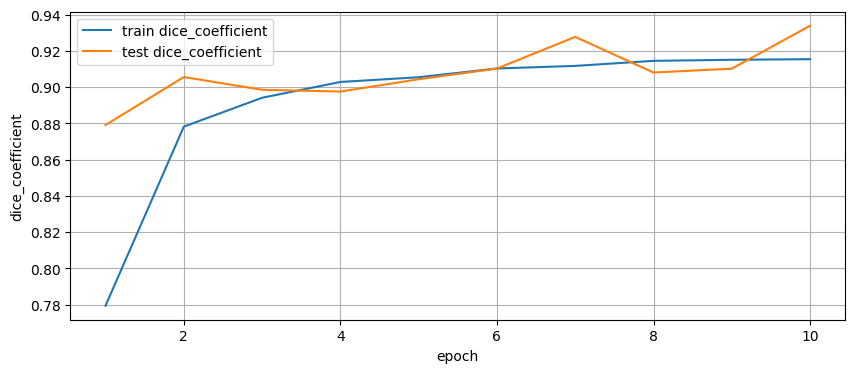


UNet model with DiceBCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.6477 - accuracy: 0.8696 - dice_coefficient: 0.7455 - jaccard_index: 0.6184 ] [ val_loss: 0.6246 - val_accuracy: 0.9661 - val_dice_coefficient: 0.8993 - val_jaccard_index: 0.8126 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6178 - accuracy: 0.9662 - dice_coefficient: 0.9017 - jaccard_index: 0.8180 ] [ val_loss: 0.6184 - val_accuracy: 0.9718 - val_dice_coefficient: 0.9171 - val_jaccard_index: 0.8424 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.6117 - accuracy: 0.9738 - dice_coefficient: 0.9242 - jaccard_index: 0.8557 ] [ val_loss: 0.6134 - val_accuracy: 0.9725 - val_dice_coefficient: 0.9208 - val_jaccard_index: 0.8504 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.6084 - accuracy: 0.9762 - dice_coefficient: 0.9313 - jaccard_index: 0.8678 ] [ val_loss: 0.6105 - val_accuracy: 0.9785 - val_dice_coefficient: 0.9374 - val_jaccard_index: 0.8775 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.6061 - accuracy: 0.9783 - dice_coefficient: 0.9377

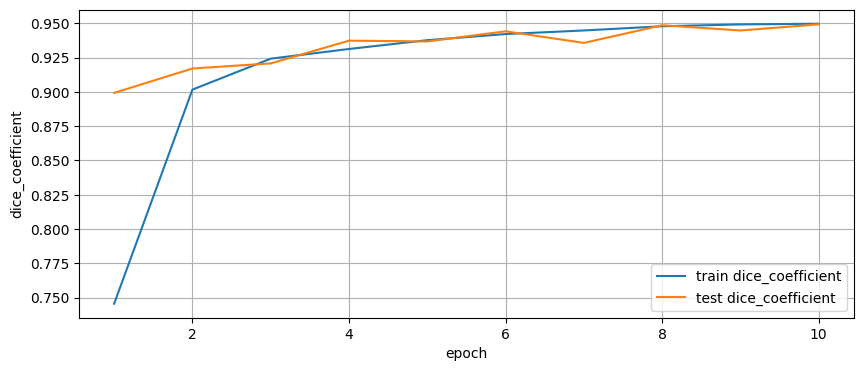


ResNet model with DiceBCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.6388 - accuracy: 0.9308 - dice_coefficient: 0.8215 - jaccard_index: 0.7136 ] [ val_loss: 0.6230 - val_accuracy: 0.9643 - val_dice_coefficient: 0.8977 - val_jaccard_index: 0.8122 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6161 - accuracy: 0.9712 - dice_coefficient: 0.9178 - jaccard_index: 0.8452 ] [ val_loss: 0.6180 - val_accuracy: 0.9733 - val_dice_coefficient: 0.9230 - val_jaccard_index: 0.8540 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.6112 - accuracy: 0.9756 - dice_coefficient: 0.9301 - jaccard_index: 0.8662 ] [ val_loss: 0.6190 - val_accuracy: 0.9786 - val_dice_coefficient: 0.9358 - val_jaccard_index: 0.8729 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.6076 - accuracy: 0.9774 - dice_coefficient: 0.9354 - jaccard_index: 0.8754 ] [ val_loss: 0.6106 - val_accuracy: 0.9775 - val_dice_coefficient: 0.9351 - val_jaccard_index: 0.8744 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.6050 - accuracy: 0.9789 - dice_coefficient: 0.94

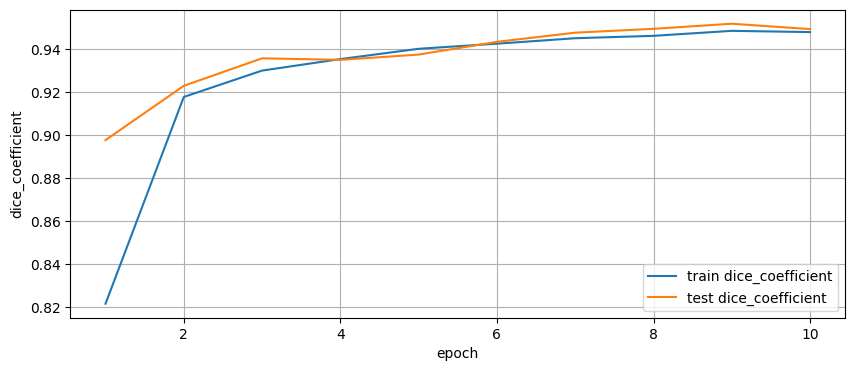


UNet model with HybridLoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.5871 - accuracy: 0.9101 - dice_coefficient: 0.7857 - jaccard_index: 0.6707 ] [ val_loss: 0.5615 - val_accuracy: 0.9697 - val_dice_coefficient: 0.9065 - val_jaccard_index: 0.8230 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.5567 - accuracy: 0.9715 - dice_coefficient: 0.9155 - jaccard_index: 0.8396 ] [ val_loss: 0.5539 - val_accuracy: 0.9741 - val_dice_coefficient: 0.9241 - val_jaccard_index: 0.8546 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.5526 - accuracy: 0.9765 - dice_coefficient: 0.9314 - jaccard_index: 0.8666 ] [ val_loss: 0.5528 - val_accuracy: 0.9784 - val_dice_coefficient: 0.9360 - val_jaccard_index: 0.8742 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.5500 - accuracy: 0.9790 - dice_coefficient: 0.9392 - jaccard_index: 0.8800 ] [ val_loss: 0.5500 - val_accuracy: 0.9799 - val_dice_coefficient: 0.9411 - val_jaccard_index: 0.8833 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.5489 - accuracy: 0.9796 - dice_coefficient: 0.9409 

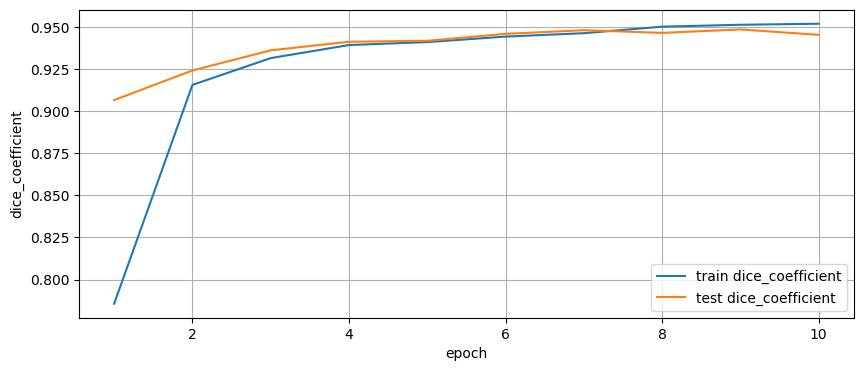


ResNet model with HybridLoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.5786 - accuracy: 0.9302 - dice_coefficient: 0.8149 - jaccard_index: 0.7095 ] [ val_loss: 0.5616 - val_accuracy: 0.9701 - val_dice_coefficient: 0.9049 - val_jaccard_index: 0.8193 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.5556 - accuracy: 0.9734 - dice_coefficient: 0.9208 - jaccard_index: 0.8481 ] [ val_loss: 0.5561 - val_accuracy: 0.9771 - val_dice_coefficient: 0.9311 - val_jaccard_index: 0.8647 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.5522 - accuracy: 0.9769 - dice_coefficient: 0.9323 - jaccard_index: 0.8678 ] [ val_loss: 0.5540 - val_accuracy: 0.9762 - val_dice_coefficient: 0.9289 - val_jaccard_index: 0.8618 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.5503 - accuracy: 0.9785 - dice_coefficient: 0.9372 - jaccard_index: 0.8761 ] [ val_loss: 0.5505 - val_accuracy: 0.9786 - val_dice_coefficient: 0.9372 - val_jaccard_index: 0.8766 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.5483 - accuracy: 0.9804 - dice_coefficient: 0.943

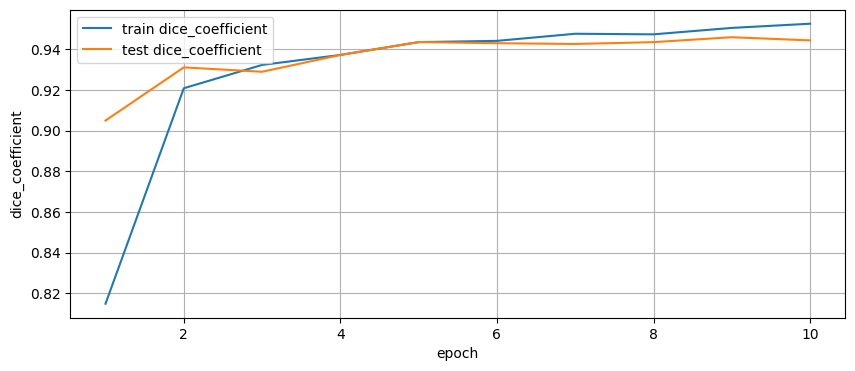


UNet model with BinaryLovaszLoss

Epoch: 1/10    Batch: 85/85   [ loss: 1.3637 - accuracy: 0.5088 - dice_coefficient: 0.2030 - jaccard_index: 0.1171 ] [ val_loss: 1.3484 - val_accuracy: 0.8437 - val_dice_coefficient: 0.0246 - val_jaccard_index: 0.0123 ]
Epoch: 2/10    Batch: 85/85   [ loss: 1.3457 - accuracy: 0.8138 - dice_coefficient: 0.0361 - jaccard_index: 0.0200 ] [ val_loss: 1.3484 - val_accuracy: 0.8454 - val_dice_coefficient: 0.0025 - val_jaccard_index: 0.0012 ]
Epoch: 3/10    Batch: 85/85   [ loss: 1.3456 - accuracy: 0.8427 - dice_coefficient: 0.0014 - jaccard_index: 0.0007 ] [ val_loss: 1.3484 - val_accuracy: 0.8456 - val_dice_coefficient: 0.0008 - val_jaccard_index: 0.0004 ]
Epoch: 4/10    Batch: 85/85   [ loss: 1.3453 - accuracy: 0.8425 - dice_coefficient: 0.0010 - jaccard_index: 0.0005 ] [ val_loss: 1.3484 - val_accuracy: 0.8456 - val_dice_coefficient: 0.0005 - val_jaccard_index: 0.0002 ]
Epoch: 5/10    Batch: 85/85   [ loss: 1.3456 - accuracy: 0.8428 - dice_coefficient: 0

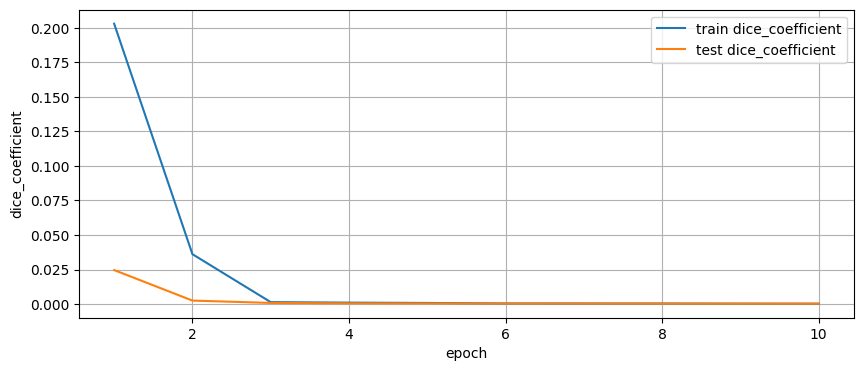


ResNet model with BinaryLovaszLoss

Epoch: 1/10    Batch: 85/85   [ loss: 1.3307 - accuracy: 0.8953 - dice_coefficient: 0.7163 - jaccard_index: 0.5846 ] [ val_loss: 1.3218 - val_accuracy: 0.9442 - val_dice_coefficient: 0.7865 - val_jaccard_index: 0.6403 ]
Epoch: 2/10    Batch: 85/85   [ loss: 1.2998 - accuracy: 0.9671 - dice_coefficient: 0.8942 - jaccard_index: 0.8011 ] [ val_loss: 1.3047 - val_accuracy: 0.9678 - val_dice_coefficient: 0.8937 - val_jaccard_index: 0.7994 ]
Epoch: 3/10    Batch: 85/85   [ loss: 1.2960 - accuracy: 0.9714 - dice_coefficient: 0.9094 - jaccard_index: 0.8260 ] [ val_loss: 1.3021 - val_accuracy: 0.9678 - val_dice_coefficient: 0.8915 - val_jaccard_index: 0.7947 ]
Epoch: 4/10    Batch: 85/85   [ loss: 1.2928 - accuracy: 0.9738 - dice_coefficient: 0.9179 - jaccard_index: 0.8402 ] [ val_loss: 1.2945 - val_accuracy: 0.9734 - val_dice_coefficient: 0.9138 - val_jaccard_index: 0.8320 ]
Epoch: 5/10    Batch: 85/85   [ loss: 1.2900 - accuracy: 0.9763 - dice_coefficient:

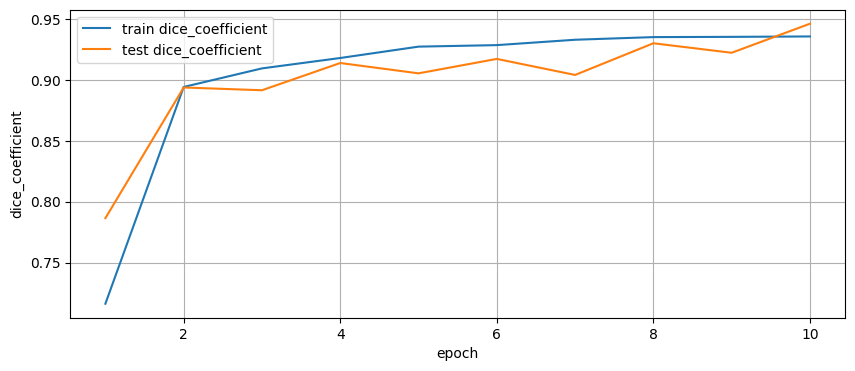


UNet model with LovaszBCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 2.0370 - accuracy: 0.6456 - dice_coefficient: 0.5245 - jaccard_index: 0.3904 ] [ val_loss: 1.9715 - val_accuracy: 0.9380 - val_dice_coefficient: 0.8161 - val_jaccard_index: 0.6867 ]
Epoch: 2/10    Batch: 85/85   [ loss: 1.9261 - accuracy: 0.9660 - dice_coefficient: 0.8910 - jaccard_index: 0.7970 ] [ val_loss: 1.9250 - val_accuracy: 0.9717 - val_dice_coefficient: 0.9096 - val_jaccard_index: 0.8266 ]
Epoch: 3/10    Batch: 85/85   [ loss: 1.9159 - accuracy: 0.9714 - dice_coefficient: 0.9104 - jaccard_index: 0.8285 ] [ val_loss: 1.9179 - val_accuracy: 0.9741 - val_dice_coefficient: 0.9185 - val_jaccard_index: 0.8418 ]
Epoch: 4/10    Batch: 85/85   [ loss: 1.9072 - accuracy: 0.9757 - dice_coefficient: 0.9257 - jaccard_index: 0.8544 ] [ val_loss: 1.9074 - val_accuracy: 0.9780 - val_dice_coefficient: 0.9324 - val_jaccard_index: 0.8654 ]
Epoch: 5/10    Batch: 85/85   [ loss: 1.9027 - accuracy: 0.9776 - dice_coefficient: 0.93

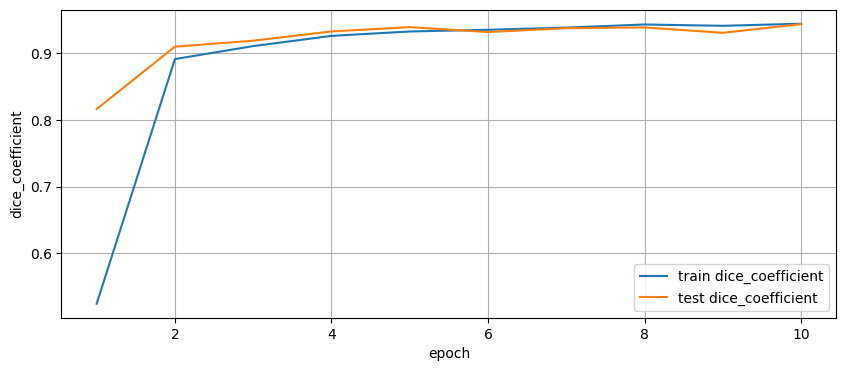


ResNet model with LovaszBCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 1.9937 - accuracy: 0.8105 - dice_coefficient: 0.7088 - jaccard_index: 0.5934 ] [ val_loss: 1.9401 - val_accuracy: 0.9637 - val_dice_coefficient: 0.8851 - val_jaccard_index: 0.7876 ]
Epoch: 2/10    Batch: 85/85   [ loss: 1.9215 - accuracy: 0.9695 - dice_coefficient: 0.9059 - jaccard_index: 0.8219 ] [ val_loss: 1.9247 - val_accuracy: 0.9726 - val_dice_coefficient: 0.9128 - val_jaccard_index: 0.8317 ]
Epoch: 3/10    Batch: 85/85   [ loss: 1.9109 - accuracy: 0.9753 - dice_coefficient: 0.9252 - jaccard_index: 0.8539 ] [ val_loss: 1.9124 - val_accuracy: 0.9754 - val_dice_coefficient: 0.9230 - val_jaccard_index: 0.8492 ]
Epoch: 4/10    Batch: 85/85   [ loss: 1.9062 - accuracy: 0.9768 - dice_coefficient: 0.9302 - jaccard_index: 0.8626 ] [ val_loss: 1.9108 - val_accuracy: 0.9759 - val_dice_coefficient: 0.9238 - val_jaccard_index: 0.8495 ]
Epoch: 5/10    Batch: 85/85   [ loss: 1.9026 - accuracy: 0.9782 - dice_coefficient: 0.

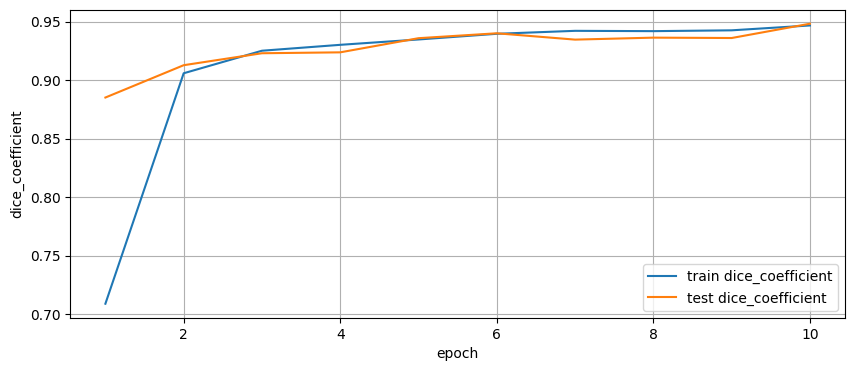

In [16]:
models.clear()
base_models_names.clear()
base_accuracies.clear()

criterions = [
    nn.MSELoss(),
    nn.BCELoss(),
    FocalLoss(),
    DiceLoss(),
    DiceBCELoss(),
    HybridLoss(),
    BinaryLovaszLoss(),
    LovaszBCELoss(),
]

for criterion in criterions:
    print('=' * 100)
    print(f"UNet model with {criterion.__class__.__name__}")
    print()
    check_loss('UNet', criterion)
    print()

    print('=' * 100)
    print(f"ResNet model with {criterion.__class__.__name__}")
    print()
    check_loss('ResNet', criterion)
    print()


In [17]:
result = list(zip(models, base_models_names, base_accuracies))
result = sorted(result, key=lambda x: x[2], reverse=True)

for item in result:
    print(f"{item[1]:<40} {item[2]:.4f}")

result = filter(lambda x: x[2] > 0.6, result)
models, base_models_names, base_accuracies = zip(*result)

ResNet model with FocalLoss              0.9527
UNet model with MSELoss                  0.9519
ResNet model with DiceBCELoss            0.9494
UNet model with DiceBCELoss              0.9493
UNet model with BCELoss                  0.9486
ResNet model with BCELoss                0.9485
ResNet model with MSELoss                0.9485
ResNet model with LovaszBCELoss          0.9482
UNet model with FocalLoss                0.9479
ResNet model with BinaryLovaszLoss       0.9461
UNet model with HybridLoss               0.9452
ResNet model with HybridLoss             0.9443
UNet model with LovaszBCELoss            0.9434
ResNet model with DiceLoss               0.9339
UNet model with DiceLoss                 0.9165
UNet model with BinaryLovaszLoss         0.0003


#Ensemble Models

In [19]:
class SimpleAverageModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(SimpleAverageModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [(model(x) > 0.5).float() for model in self.models]
        average = torch.mean(torch.stack(outputs), dim=0)
        return average


class MajorityVotingModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(MajorityVotingModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) > 0.5 for model in self.models]
        mask_tensor = torch.stack(outputs, dim=0)

        # Majority voting
        ensemble_mask = mask_tensor.sum(dim=0) > len(models) // 2

        return ensemble_mask


class BitwiseAndModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(BitwiseAndModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) > 0.5 for model in self.models]
        stack = torch.stack(outputs, dim=0)

        result = stack[0]
        for i in range(1, len(stack)):
            result = torch.bitwise_and(result, stack[i])

        return result


class BitwiseOrModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(BitwiseOrModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) > 0.5 for model in self.models]
        stack = torch.stack(outputs, dim=0)

        result = stack[0]
        for i in range(1, len(stack)):
            result = torch.bitwise_or(result, stack[i])

        return result


class WeightedAverageModel(nn.Module):
    trainable = False

    def __init__(self, models, weights):
        super(WeightedAverageModel, self).__init__()
        self.models = models
        self.len_models = len(self.models)
        self.weights = F.softmax(torch.tensor(weights), dim=0)

    def forward(self, x):
        s = 0
        for i in range(self.len_models):
            s += self.weights[i] * (self.models[i](x) > 0.5)
        return s


class StackingMetaModel(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(StackingMetaModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class StackingModel(nn.Module):
    trainable = True

    def __init__(self, models, meta_model):
        super(StackingModel, self).__init__()
        self.models = models
        self.len_models = len(self.models)
        self.output = meta_model

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        stack = torch.cat(outputs, dim=1)
        output = self.output(stack)
        return F.sigmoid(output)


#Checking different ensemble models

In [20]:
ensemble_models_names = []
ensemble_accuracies = []

def check_ensemble_model(ensemble_model, criterion):
    if ensemble_model.trainable:
        model_fit = ModelFit(ensemble_model, criterion)
        history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)
        plot_metric(history, 'dice_coefficient')
        model_accuracy = history['val_dice_coefficient'][-1]

    else:
        for metric in [accuracy, dice_coefficient, jaccard_index]:
            model_accuracy = evaluate(ensemble_model, test_loader, metric=metric)
            print(f"{metric.__name__ }: {model_accuracy:.4f}")
        model_accuracy = evaluate(ensemble_model, test_loader)

    name = f"{ensemble_model.__class__.__name__}"
    ensemble_models_names.append(name)
    ensemble_accuracies.append(model_accuracy)

    for i in range(0):
        print()
        check(ensemble_model, i)


Ensemble model: SimpleAverageModel

accuracy: 0.9852
dice_coefficient: 0.9585
jaccard_index: 0.9140

Ensemble model: MajorityVotingModel

accuracy: 0.9852
dice_coefficient: 0.9585
jaccard_index: 0.9140

Ensemble model: BitwiseAndModel

accuracy: 0.9759
dice_coefficient: 0.9225
jaccard_index: 0.8459

Ensemble model: BitwiseOrModel

accuracy: 0.9611
dice_coefficient: 0.8914
jaccard_index: 0.8036

Ensemble model: WeightedAverageModel

accuracy: 0.9852
dice_coefficient: 0.9585
jaccard_index: 0.9140

Ensemble model: StackingModel

Epoch: 1/10    Batch: 85/85   [ loss: 0.6133 - accuracy: 0.9785 - dice_coefficient: 0.9404 - jaccard_index: 0.8859 ] [ val_loss: 0.6116 - val_accuracy: 0.9758 - val_dice_coefficient: 0.9315 - val_jaccard_index: 0.8701 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.6065 - accuracy: 0.9822 - dice_coefficient: 0.9510 - jaccard_index: 0.9043 ] [ val_loss: 0.6085 - val_accuracy: 0.9802 - val_dice_coefficient: 0.9441 - val_jaccard_index: 0.8915 ]
Epoch: 3/10    Batch: 85/85 

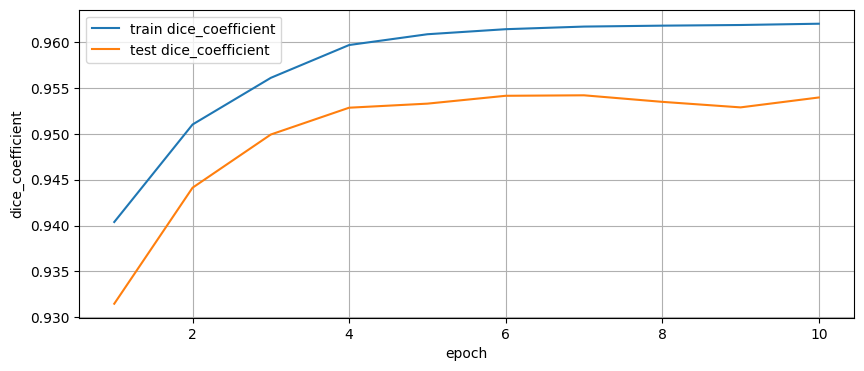

In [21]:
ensemble_models_names.clear()
ensemble_accuracies.clear()

for model in models:
    model.eval()

criterion = nn.BCELoss()

ensemble_models = [
    SimpleAverageModel(models),
    MajorityVotingModel(models),
    BitwiseAndModel(models),
    BitwiseOrModel(models),
    WeightedAverageModel(models, weights=base_accuracies),
    StackingModel(models, meta_model=StackingMetaModel(in_ch=len(models), out_ch=1)),
]

for ensemble_model in ensemble_models:
    print('=' * 100)
    print(f"Ensemble model: {ensemble_model.__class__.__name__}")
    print()
    check_ensemble_model(ensemble_model, criterion)
    print()


In [22]:
result = list(zip(ensemble_models_names, ensemble_accuracies))
result = sorted(result, key=lambda x: x[1], reverse=True)

for item in result:
    print(f"{item[0]:<40} {item[1]:.4f}")

SimpleAverageModel                       0.9585
MajorityVotingModel                      0.9585
WeightedAverageModel                     0.9585
StackingModel                            0.9540
BitwiseAndModel                          0.9225
BitwiseOrModel                           0.8914


# Attention Models

In [23]:
import sys

sys.path.append('Image_Segmentation')

from Image_Segmentation.network import AttU_Net
from Image_Segmentation.network import R2AttU_Net


sys.path.append('Dual_Cross_Attention')

from Dual_Cross_Attention.model.unet import Unet
from Dual_Cross_Attention.model.vnet import Vnet
from Dual_Cross_Attention.model.res_unet_plus import ResUnetPlus
from Dual_Cross_Attention.model.r2_unet import R2Unet
from Dual_Cross_Attention.model.double_unet import DoubleUnet
from Dual_Cross_Attention.model.multi_res_unet import MultiResUnet

In [24]:
input_size = (image_size, image_size)

class AttentionModel(nn.Module):
    def __init__(self, base_model):
        super(AttentionModel, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        output = self.base_model(x)
        return F.sigmoid(output)


attention_models = [
    AttentionModel(AttU_Net     (img_ch=1, output_ch=1)),
    AttentionModel(R2AttU_Net   (img_ch=1, output_ch=1)),

    AttentionModel(Unet         (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(Vnet         (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(ResUnetPlus  (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(R2Unet       (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(MultiResUnet (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
]

In [27]:
epochs = 10

attention_models_names = []
attention_accuracies = []

def check_attention_model(model, criterion):

    model_fit = ModelFit(model, criterion)
    history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)

    name = f"{model.base_model.__class__.__name__} model with {criterion.__class__.__name__}"
    attention_models_names.append(name)
    attention_accuracies.append(history['val_dice_coefficient'][-1])

    plot_metric(history, 'dice_coefficient')

    for i in range(0):
        print()
        check(model, i)


AttU_Net model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.2639 - accuracy: 0.9353 - dice_coefficient: 0.8537 - jaccard_index: 0.7575 ] [ val_loss: 0.1358 - val_accuracy: 0.9716 - val_dice_coefficient: 0.9112 - val_jaccard_index: 0.8303 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.1021 - accuracy: 0.9743 - dice_coefficient: 0.9235 - jaccard_index: 0.8523 ] [ val_loss: 0.0739 - val_accuracy: 0.9777 - val_dice_coefficient: 0.9334 - val_jaccard_index: 0.8687 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0704 - accuracy: 0.9764 - dice_coefficient: 0.9299 - jaccard_index: 0.8632 ] [ val_loss: 0.0744 - val_accuracy: 0.9724 - val_dice_coefficient: 0.9190 - val_jaccard_index: 0.8459 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0554 - accuracy: 0.9790 - dice_coefficient: 0.9387 - jaccard_index: 0.8785 ] [ val_loss: 0.0500 - val_accuracy: 0.9804 - val_dice_coefficient: 0.9419 - val_jaccard_index: 0.8832 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0475 - accuracy: 0.9808 - dice_coefficient: 0.9444 

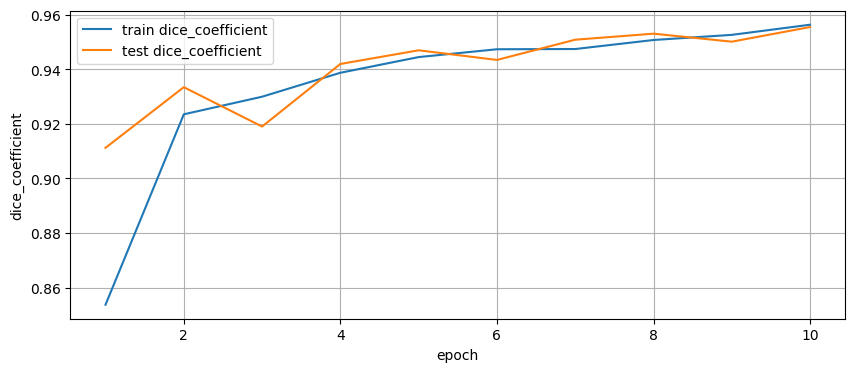


R2AttU_Net model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.1847 - accuracy: 0.9138 - dice_coefficient: 0.6812 - jaccard_index: 0.5799 ] [ val_loss: 0.4176 - val_accuracy: 0.8661 - val_dice_coefficient: 0.6338 - val_jaccard_index: 0.4628 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.0737 - accuracy: 0.9682 - dice_coefficient: 0.9024 - jaccard_index: 0.8168 ] [ val_loss: 0.3042 - val_accuracy: 0.9155 - val_dice_coefficient: 0.7771 - val_jaccard_index: 0.6346 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0611 - accuracy: 0.9729 - dice_coefficient: 0.9188 - jaccard_index: 0.8441 ] [ val_loss: 0.5089 - val_accuracy: 0.8747 - val_dice_coefficient: 0.7042 - val_jaccard_index: 0.5432 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0514 - accuracy: 0.9768 - dice_coefficient: 0.9314 - jaccard_index: 0.8658 ] [ val_loss: 0.1554 - val_accuracy: 0.9521 - val_dice_coefficient: 0.8514 - val_jaccard_index: 0.7384 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0472 - accuracy: 0.9784 - dice_coefficient: 0.93

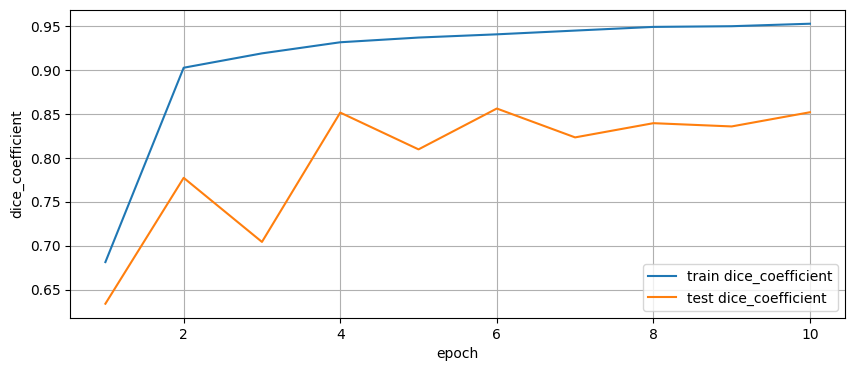


Unet model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.3643 - accuracy: 0.9337 - dice_coefficient: 0.8615 - jaccard_index: 0.7692 ] [ val_loss: 0.2565 - val_accuracy: 0.9714 - val_dice_coefficient: 0.9098 - val_jaccard_index: 0.8277 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.1783 - accuracy: 0.9740 - dice_coefficient: 0.9225 - jaccard_index: 0.8508 ] [ val_loss: 0.1319 - val_accuracy: 0.9772 - val_dice_coefficient: 0.9329 - val_jaccard_index: 0.8694 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.1057 - accuracy: 0.9776 - dice_coefficient: 0.9341 - jaccard_index: 0.8708 ] [ val_loss: 0.0832 - val_accuracy: 0.9805 - val_dice_coefficient: 0.9431 - val_jaccard_index: 0.8867 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0757 - accuracy: 0.9789 - dice_coefficient: 0.9384 - jaccard_index: 0.8781 ] [ val_loss: 0.0621 - val_accuracy: 0.9822 - val_dice_coefficient: 0.9484 - val_jaccard_index: 0.8956 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0578 - accuracy: 0.9815 - dice_coefficient: 0.9468 - j

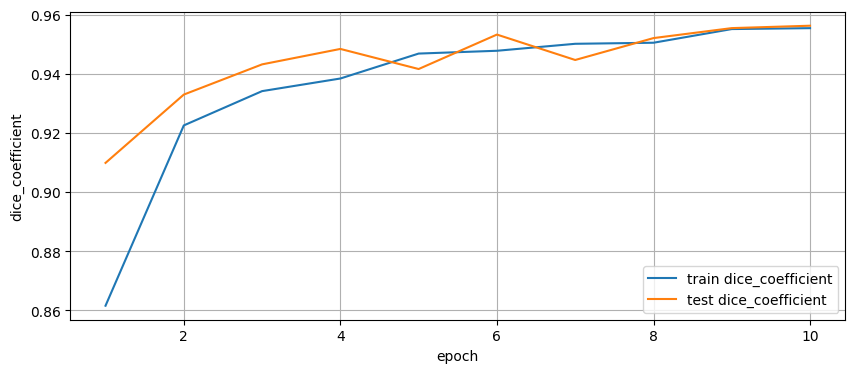


Vnet model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.2957 - accuracy: 0.9349 - dice_coefficient: 0.8387 - jaccard_index: 0.7343 ] [ val_loss: 0.1755 - val_accuracy: 0.9660 - val_dice_coefficient: 0.8953 - val_jaccard_index: 0.8053 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.1264 - accuracy: 0.9702 - dice_coefficient: 0.9108 - jaccard_index: 0.8314 ] [ val_loss: 0.1036 - val_accuracy: 0.9668 - val_dice_coefficient: 0.8924 - val_jaccard_index: 0.7987 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0802 - accuracy: 0.9747 - dice_coefficient: 0.9252 - jaccard_index: 0.8557 ] [ val_loss: 0.0786 - val_accuracy: 0.9733 - val_dice_coefficient: 0.9171 - val_jaccard_index: 0.8404 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0637 - accuracy: 0.9768 - dice_coefficient: 0.9316 - jaccard_index: 0.8665 ] [ val_loss: 0.0626 - val_accuracy: 0.9761 - val_dice_coefficient: 0.9291 - val_jaccard_index: 0.8619 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0533 - accuracy: 0.9791 - dice_coefficient: 0.9392 - j

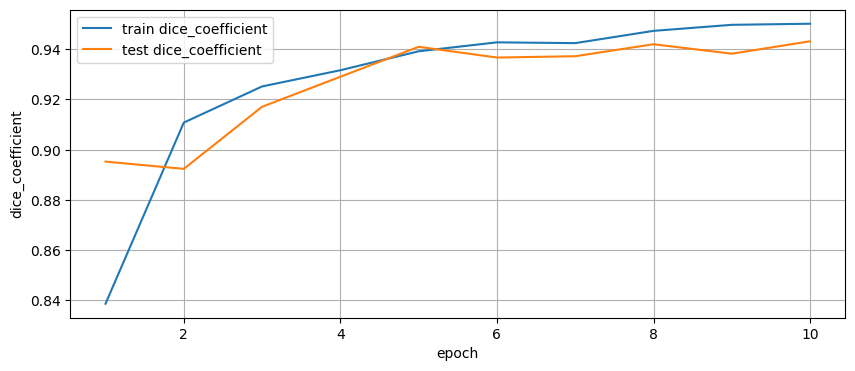


ResUnetPlus model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.4496 - accuracy: 0.8656 - dice_coefficient: 0.4832 - jaccard_index: 0.3870 ] [ val_loss: 0.3633 - val_accuracy: 0.8457 - val_dice_coefficient: 0.0012 - val_jaccard_index: 0.0006 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.1483 - accuracy: 0.9613 - dice_coefficient: 0.8819 - jaccard_index: 0.7846 ] [ val_loss: 0.1376 - val_accuracy: 0.9552 - val_dice_coefficient: 0.8644 - val_jaccard_index: 0.7575 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0862 - accuracy: 0.9721 - dice_coefficient: 0.9165 - jaccard_index: 0.8407 ] [ val_loss: 0.0764 - val_accuracy: 0.9727 - val_dice_coefficient: 0.9153 - val_jaccard_index: 0.8376 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0624 - accuracy: 0.9773 - dice_coefficient: 0.9333 - jaccard_index: 0.8693 ] [ val_loss: 0.0520 - val_accuracy: 0.9801 - val_dice_coefficient: 0.9409 - val_jaccard_index: 0.8814 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0522 - accuracy: 0.9796 - dice_coefficient: 0.9

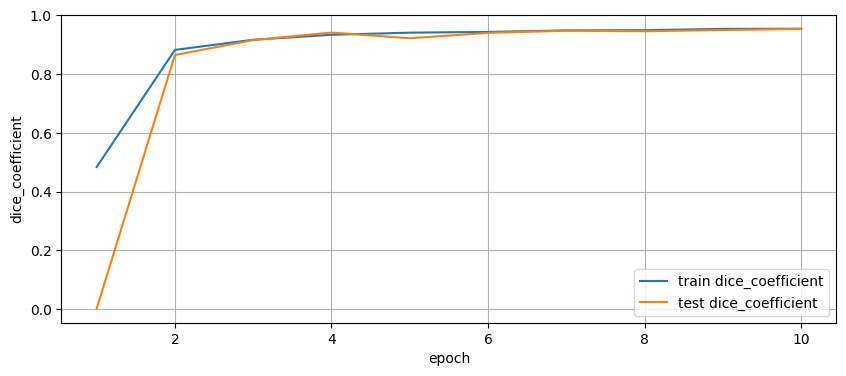


R2Unet model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.3174 - accuracy: 0.9191 - dice_coefficient: 0.8245 - jaccard_index: 0.7217 ] [ val_loss: 0.2206 - val_accuracy: 0.9560 - val_dice_coefficient: 0.8558 - val_jaccard_index: 0.7424 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.1329 - accuracy: 0.9737 - dice_coefficient: 0.9225 - jaccard_index: 0.8513 ] [ val_loss: 0.1302 - val_accuracy: 0.9650 - val_dice_coefficient: 0.8997 - val_jaccard_index: 0.8155 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0868 - accuracy: 0.9758 - dice_coefficient: 0.9287 - jaccard_index: 0.8617 ] [ val_loss: 0.0756 - val_accuracy: 0.9777 - val_dice_coefficient: 0.9344 - val_jaccard_index: 0.8720 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0627 - accuracy: 0.9799 - dice_coefficient: 0.9420 - jaccard_index: 0.8848 ] [ val_loss: 0.0593 - val_accuracy: 0.9800 - val_dice_coefficient: 0.9415 - val_jaccard_index: 0.8843 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0542 - accuracy: 0.9805 - dice_coefficient: 0.9437 -

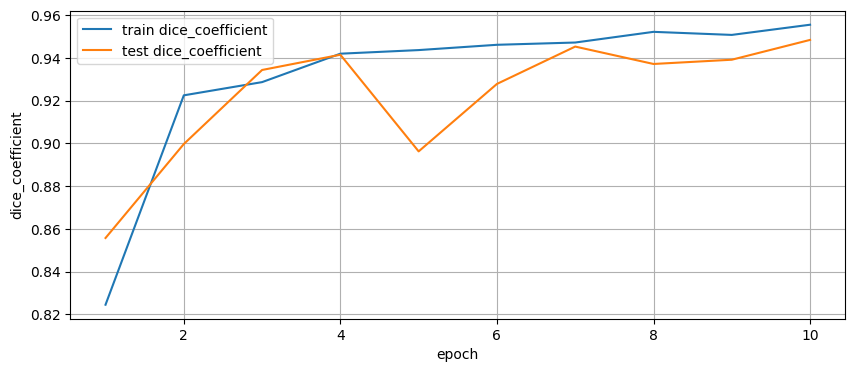


MultiResUnet model with BCELoss

Epoch: 1/10    Batch: 85/85   [ loss: 0.1312 - accuracy: 0.9563 - dice_coefficient: 0.8477 - jaccard_index: 0.7594 ] [ val_loss: 0.0740 - val_accuracy: 0.9708 - val_dice_coefficient: 0.9142 - val_jaccard_index: 0.8377 ]
Epoch: 2/10    Batch: 85/85   [ loss: 0.0530 - accuracy: 0.9778 - dice_coefficient: 0.9346 - jaccard_index: 0.8713 ] [ val_loss: 0.0472 - val_accuracy: 0.9793 - val_dice_coefficient: 0.9380 - val_jaccard_index: 0.8764 ]
Epoch: 3/10    Batch: 85/85   [ loss: 0.0455 - accuracy: 0.9799 - dice_coefficient: 0.9416 - jaccard_index: 0.8835 ] [ val_loss: 0.0416 - val_accuracy: 0.9814 - val_dice_coefficient: 0.9457 - val_jaccard_index: 0.8904 ]
Epoch: 4/10    Batch: 85/85   [ loss: 0.0396 - accuracy: 0.9819 - dice_coefficient: 0.9481 - jaccard_index: 0.8952 ] [ val_loss: 0.0374 - val_accuracy: 0.9830 - val_dice_coefficient: 0.9507 - val_jaccard_index: 0.8989 ]
Epoch: 5/10    Batch: 85/85   [ loss: 0.0375 - accuracy: 0.9825 - dice_coefficient: 0.

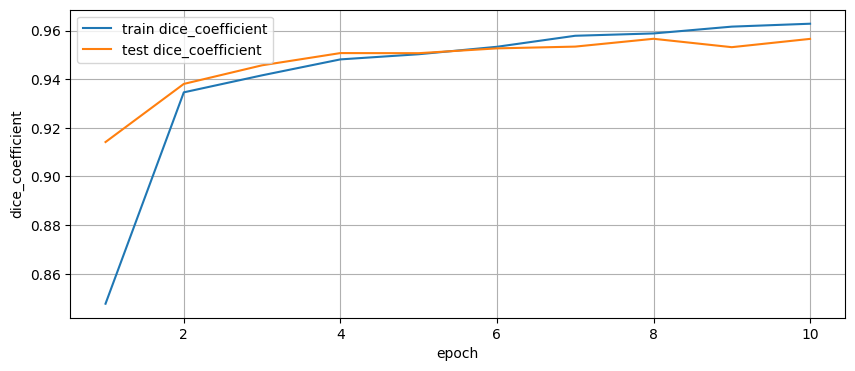

In [28]:
attention_models_names.clear()
attention_accuracies.clear()

criterions = [
    # nn.MSELoss(),
    nn.BCELoss(),
    # FocalLoss(),
    # DiceLoss(),
    # DiceBCELoss(),
    # HybridLoss(),
    # BinaryLovaszLoss(),
    # LovaszBCELoss(),
]

for model in attention_models:
    for criterion in criterions:
        print('=' * 100)
        print(f"{model.base_model.__class__.__name__} model with {criterion.__class__.__name__}")
        print()
        check_attention_model(model, criterion)
        print()

In [29]:
result = list(zip(attention_models_names, attention_accuracies))
result = sorted(result, key=lambda x: x[1], reverse=True)

for item in result:
    print(f"{item[0]:<40} {item[1]:.4f}")

MultiResUnet model with BCELoss          0.9566
Unet model with BCELoss                  0.9562
AttU_Net model with BCELoss              0.9554
ResUnetPlus model with BCELoss           0.9532
R2Unet model with BCELoss                0.9485
Vnet model with BCELoss                  0.9432
R2AttU_Net model with BCELoss            0.8518
